In [55]:
'''
#Gigacow-tools# - preprocessing
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#access data from local directory
dataDir = Path.cwd().parent.parent/'Data/processed'
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'Age']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir/'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir/'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

5613    11903
6197    11250
4478    11054
3757    10907
2423    10864
3147    10083
4504    10016
5147     9758
3121     9518
5046     9390
Name: Gigacow_Cow_Id, dtype: int64


In [56]:
# Select cows with sufficient data points on consecutive lactation periods
# Try to collect cow's data that contain milking events between lactation periods 1~2
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)

# fetch all milking traffic events for merging
traffic_milking = traffic.TrafficResult.str.contains('kg', regex=False)
all_list = traffic_milking.index[traffic_milking.values == True].tolist()
milking_total = traffic[traffic.index.isin(all_list)]
milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date
# convert data type
milking_total.milking_date = pd.to_datetime(milking_total.milking_date)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
# merge all milking events with lactation table for filtering
milking_total = milking_total.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'milking_date'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])

# select records that contains lactation period 1
milking_select1 = milking_total.loc[milking_total['LactationNumber'] == 1]
milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
selected1 = milking_select1.Gigacow_Cow_Id.value_counts(ascending=True)
selected1 = selected1.loc[(selected1.values > 200) & (selected1.values < 400)]
list1 = selected1.index.to_list()
# select records that contains lactation period 2
milking_select2 = milking_total.loc[milking_total['LactationNumber'] == 2]
milking_select2.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
selected2 = milking_select2.Gigacow_Cow_Id.value_counts(ascending=True)
selected2 = selected2.loc[(selected2.values > 200) & (selected2.values < 400)]
list2 = selected2.index.to_list()
cow_list = list(set(list1) & set(list2))
cow_list

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_34356\2962455715.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_34356\2962455715.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_34356\2962455715.py:13: SettingWithCopyWarning: 
A value is tryin

[478, 3718, 2569, 74, 6380, 1103, 1555, 182, 5046, 5147, 1181, 926, 2423]

In [57]:
#select single cow from the traffic table
traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == 478]
traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
traffic_single_cow.index = range(len(traffic_single_cow))

'''
    Extract Milking Event and its most recent traffic event to calculate T2-T1
    T1: Entry time into the Mjolkfalla
    T2: Entry time into the milking robot
    T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
'''
# locate mikling event by searching 'kg' keyword in traffic result
# the most recent traffic event to milking event should be pre_milking event
# need to filter out records with gate failure
track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
milking_index_list = track_milking.index[track_milking.values == True].tolist()
pre_milking_index_list = [x-1 for x in milking_index_list]
milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

# drop rows that the gate failed to detect cows but have milking result
# previous area in milking_traffic table should only be Mjolkfalla
# previous area in pre_milking_traffic table should not be Mjolkfalla
failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
failed_list_1_pre = [x-1 for x in failed_list_1_milk]
failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
failed_list_2_milk = [x+1 for x in failed_list_2_pre]
# traffic result in pre_milking_traffic table should contain Mjolkfalla
track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
failed_list_3_milk = [x+1 for x in failed_list_3_pre]

# remove failed records based on index list
milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
# concatenate two tables to track the traffic directly
all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
#rename table columns for merging
milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
# unify the index of two tables
milking_traffic.index = range(len(milking_traffic))
pre_milking_traffic.index = range(len(pre_milking_traffic))
# inert "pre_traffic_milking" to milking traffic table
milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
# calculate T2-T1
milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

#extract traffic result(milk production)
milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

# merge all the other features into milking_traffic table
milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

# drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)
single_cow_merge['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)

# write the collection result to local directory
#single_cow_collection = single_cow_merge[['Gigacow_Cow_Id', 'BreedName', 'Age', 'FarmName_Pseudo', 'GroupName', 'TrafficDeviceName', 'MilkProduction', 'timeDelta_Seconds', 'LactationNumber', 'DaysInMilk']]

single_cow_merge.to_csv(dataDir/'single_cow_merge.csv')

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_34356\26146190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_34356\26146190.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_34356\26146190.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

<Figure size 432x288 with 0 Axes>

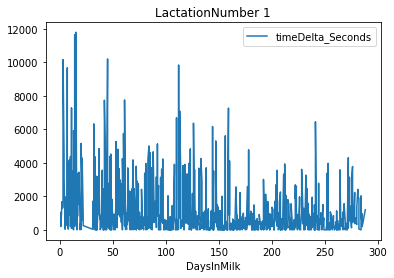

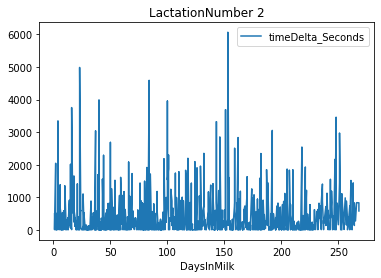

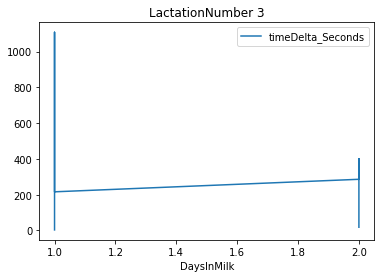

In [58]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


In [4]:
#all_milking_traffic.to_csv(dataDir/'all_milking_traffic.csv')
all_milking_traffic
#pre_milking_traffic.to_csv(dataDir/'pre_milking_traffic.csv')
pre_milking_traffic
#milking_traffic.to_csv(dataDir/'milking_traffic.csv')
milking_traffic
#single_cow_merge.to_csv(dataDir/'single_cow_merge.csv')
single_cow_merge

,Traffic_Id,FarmName_Pseudo,Gigacow_Cow_Id,GroupName,MilkingEventDateTime,Pre_MilkingEventDateTime,PreviousArea,RoundedSecondsTimeInArea,TrafficDeviceName,MilkProduction,MilkingInterval_totalSeconds,timeDelta_Seconds,MilkingDate,LactationInfoDate,LactationNumber,DaysInMilk,BreedName,Age
0,518364,a624fb9a,129,VMS 1,2020-08-17 10:52:55,2020-08-17 10:33:16,Mjolkfalla,1140,vms1,15.31,47520.0,1179.0,2020-08-17,2020-08-17,1,180.0,1,4.77
1,307150,a624fb9a,129,VMS 1,2020-08-17 18:41:18,2020-08-17 18:27:40,Mjolkfalla,780,vms1,9.98,27600.0,818.0,2020-08-17,2020-08-17,1,180.0,1,4.77
2,516645,a624fb9a,129,VMS 1,2020-08-18 00:57:31,2020-08-18 00:57:18,Mjolkfalla,0,vms1,8.35,22140.0,13.0,2020-08-18,2020-08-18,1,181.0,1,4.77
3,570026,a624fb9a,129,VMS 1,2020-08-18 10:25:20,2020-08-18 10:24:19,Mjolkfalla,60,vms1,12.69,33720.0,61.0,2020-08-18,2020-08-18,1,181.0,1,4.77
4,108524,a624fb9a,129,VMS 1,2020-08-18 18:35:57,2020-08-18 18:34:23,Mjolkfalla,60,vms1,10.68,28980.0,94.0,2020-08-18,2020-08-18,1,181.0,1,4.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,4581487,a624fb9a,129,VMS 1,2022-08-22 12:59:54,2022-08-22 12:57:02,Mjolkfalla,120,vms2,15.94,37560.0,172.0,2022-08-22,2022-08-22,3,223.0,1,4.77
1680,3379343,a624fb9a,129,VMS 1,2022-08-22 19:27:04,2022-08-22 19:24:48,Mjolkfalla,120,vms2,9.69,22740.0,136.0,2022-08-22,2022-08-22,3,223.0,1,4.77
1681,10472864,a624fb9a,129,VMS 1,2022-08-23 06:24:17,2022-08-23 06:24:06,Mjolkfalla,0,vms2,14.98,39060.0,11.0,2022-08-23,2022-08-23,3,224.0,1,4.77
1682,1232746,a624fb9a,129,VMS 1,2022-08-23 13:27:01,2022-08-23 12:49:26,Mjolkfalla,2220,vms2,10.65,24900.0,2255.0,2022-08-23,2022-08-23,3,224.0,1,4.77
